In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.datasets import load_digits
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn import preprocessing

In [ ]:
class Perceptron:
    weights: np.array
    bias: float
    learning_rate: float
    activation_function: str
    loss_function: str
    train_accuracy: float

    def fit(
        self,
        features: np.array,
        labels: np.array,
        learning_rate=0.0001,
        epochs=100,
        activation_function='binary',
        loss='mse',
        batch_size=None
    ):
        if loss not in ['gd', 'mse']:
            raise ValueError('Invalid Loss Function')

        self.loss_function = loss
        self.activation_function = activation_function
        self.learning_rate = learning_rate

        n_samples, n_features = features.shape

        if batch_size == None:
            batch_size = n_samples

        self.weights = np.array(
            [random.uniform(-1, 1) for _ in range(n_features)]
        )
        self.bias = 1

        itt = 0
        while itt < epochs:
            errors_counter = 0
            for m in range(math.ceil(n_samples/batch_size)):
                start = m * batch_size
                end = start + batch_size

                if end >= n_samples:
                    end = n_samples

                x_partial = features[start:end]
                weighted_sums = x_partial.dot(self.weights.T) + self.bias

                y_pred = self._activation_function(weighted_sums)

                errors = np.subtract(labels[start:end], y_pred)
                self._update_weights(x_partial, errors)

                errors_counter += np.count_nonzero(labels[start:end] - self._binary(y_pred)) / errors.shape[0]

            self.train_accuracy = 1 - (errors_counter / (n_samples/batch_size))
            itt += 1

    def _mse_update(self, x, errors):
        n_samples = len(errors)
        self.weights += (2 * self.learning_rate * (x.T).dot(errors)) / n_samples
        self.bias += (2 * self.learning_rate * np.sum(errors)) / n_samples

    def _gd_update(self, x, errors):
        self.weights += self.learning_rate * (x.T).dot(errors)
        self.bias += self.learning_rate * np.sum(errors)

    def _update_weights(self, x, errors):
        if self.loss_function == 'mse':
            self._mse_update(x, errors)
            return

        if self.loss_function == 'gd':
            self._gd_update(x, errors)
            return

    def _activation_function(self, weighted_sums):
        if self.activation_function == 'relu':
            return self._relu(weighted_sums, 0)

        if self.activation_function == 'l_relu':
            return self._relu(weighted_sums, 0.01)

        if self.activation_function == 'sigmoid':
            return self._sigmoid(weighted_sums)

        if self.activation_function == 'tanh':
            return self._tanh(weighted_sums)

        if self.activation_function == 'binary':
            return self._binary(weighted_sums)

        raise ValueError('Invalid Activation Function!')

    def _relu(self, weighted_sum, rate):
        output = np.where(weighted_sum < 0, rate*weighted_sum, weighted_sum)
        return output

    def _sigmoid(self, weighted_sum):
        output = 1 / (1 - np.power(math.e, weighted_sum))
        return output

    def _tanh(self, weighted_sum):
        return np.tanh(weighted_sum)

    def _binary(self, weighted_sum):
        return np.where(weighted_sum < 0.5, 0, 1)

    def predict(self, features: pd.DataFrame):
        weighted_sums = np.add(features.dot(self.weights.T), self.bias)
        y_pred = self._activation_function(weighted_sums)

        return y_pred

    @property
    def get_weights(self):
        return self.weights

    @property
    def get_bias(self):
        return self.bias

    @property
    def get_acc(self):
        return self.train_accuracy

In [ ]:
class MultiPerceptron:
    perceptrons: list
    train_accs: list
    classes: list
    n_classes: int

    def fit(
        self,
        features,
        labels,
        learning_rate=0.0001,
        epochs=1000,
        activation_function='relu',
        loss='mse',
        batch_size=None
    ):
        self.train_accs = []
        self.classes = np.unique(labels).tolist()
        self.n_classes = len(self.classes)
        self.perceptrons = [Perceptron() for _ in range(self.n_classes)]

        for index, perceptron in enumerate(self.perceptrons):
            cls = self.classes[index]
            perceptron.fit(
                np.array(features),
                self.update_label(cls, labels),
                learning_rate=learning_rate,
                epochs=epochs,
                activation_function=activation_function,
                loss=loss,
                batch_size=batch_size
            )

            self.train_accs.append(perceptron.get_acc)

        print(self.train_accs)

    def predict(self, features):
        predictions = []
        for perceptron in self.perceptrons:
            y_pred = perceptron.predict(features)
            predictions.append(y_pred)

        predictions = np.column_stack(predictions)
        print(predictions)
        predictions = np.argmax(predictions * self.train_accs, axis=1)

        return predictions

    def update_label(self, cls, df: pd.DataFrame):
        return np.where(df==cls, 1, 0)

In [ ]:
digits = load_digits()

data = digits.data
label = digits.target

df = {str(x): [] for x in range(64)}
for row in data:
    for index, gs_number in enumerate(row):
        df[str(index)].append(gs_number)
df["target"] = label

df = pd.DataFrame(data=df)
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


In [ ]:
features = df.drop(columns='target')
labels = df['target']

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=2)

In [ ]:
scaler = preprocessing.Normalizer().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_val[0].shape

(64,)

#Treinamento

In [73]:
mp = MultiPerceptron()

mp.fit(np.array(x_train), np.array(y_train), 0.05, 10000, 'relu', 'mse')

[0.9972164231036882, 0.9721642310368824, 0.9951287404314544, 0.9867780097425192, 0.9916492693110647, 0.9909533750869868, 0.9951287404314544, 0.9923451635351427, 0.9659011830201809, 0.9832985386221295]


#Validação

In [74]:
y_pred = mp.predict(np.array(x_val))
print(len(y_val), np.count_nonzero(y_val - y_pred))

[[-0.         -0.         -0.         ... -0.          0.27521563
  -0.        ]
 [-0.          0.79966781 -0.         ... -0.          0.13362501
  -0.        ]
 [ 0.29228768 -0.         -0.         ... -0.         -0.
   0.6796416 ]
 ...
 [-0.          0.75317144 -0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ...  0.58392534 -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]]
180 10


#Teste

In [75]:
y_pred = mp.predict(np.array(x_test))
print(len(y_test), np.count_nonzero(y_test - y_pred))

[[-0.         -0.         -0.         ...  1.03595567 -0.
  -0.        ]
 [-0.         -0.         -0.         ...  1.20375088 -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
   0.12187481]
 ...
 [-0.          0.17650447 -0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
   1.22718102]
 [-0.          0.05859491 -0.         ... -0.         -0.
  -0.        ]]
180 12


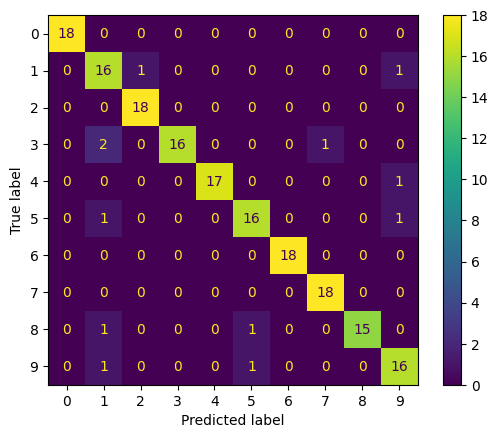

In [76]:
cm = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(cm)

cm.plot()
plt.show()

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.76      0.89      0.82        18
           2       0.95      1.00      0.97        18
           3       1.00      0.84      0.91        19
           4       1.00      0.94      0.97        18
           5       0.89      0.89      0.89        18
           6       1.00      1.00      1.00        18
           7       0.95      1.00      0.97        18
           8       1.00      0.88      0.94        17
           9       0.84      0.89      0.86        18

    accuracy                           0.93       180
   macro avg       0.94      0.93      0.93       180
weighted avg       0.94      0.93      0.93       180

